# Correlating Spike Trains

This lesson is based on Chapter 4 of Nylen, E.L., and Wallisch, P.. (2017). [*Neural Data Science*](https://www.sciencedirect.com/book/9780128040430/neural-data-science). Academic Press. 

The data file used in this tutorial is freely available from [the book's website](https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files), as is Nylen and Wallisch's original code. 

The code provided here, along with the explanatory test, was written by by Aaron J. Newman and is distributed under the same license as the rest of this book. 

## About the data

The data used here are from a study published by Snyder, Morais, Willis, and Smith (2015). The goal of the study was to relate neural activity across different scales, from single unit (single neuron) to whole-brain networks. To do this, the researchers simultaneously recorded neural activity from a 96-electrode array implanted in the brain, and EEG electrodes on the scalp, of rhesus macaque monkeys. Here we will work with only the 96 electrode invasive recordings, and not the EEG. Of interest is **spike count correlation**, which is a measure of neural functional connectivity. Functional connectivity is of widespread interest in neuroscience, and essentially refers to correlations in activity between different brain areas. If different brain areas (or individual neurons) show correlated activity, it is likely that they work together in some way. This is particularly true if their functional connectivity changes as a result of experimental manipulations. For example, if two areas (or neurons) show stronger correlation during a particular task than during a control condition, then we might infer that their functional connectivity is related to their involvement in the experimental task. Indeed, in their introduction Snyder and colleagues note that spike count correlations are structured and modulated by both perceptual and cognitive manipulations.

### Recording
The data were recorded from a Utah intracortical electrode array (Maynard, Nordhausen, & Normann, 1997) implanted in area V4 of the visual cortex. The Utah array is shown in the figure below:

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cd/Utah_array_pat5215088.jpg" width=250 alt="Utah microelectrode array">

This is a type of [microelectrode array](https://en.wikipedia.org/wiki/Microelectrode_array) consisting of a 10 x 10 grid of silicon microelectrodes that can be placed directly on the cortical surface of a living animal, covering an area of approximately 16 mm<sup>2</sup>. Each electrode is ~1 mm long, and the tip of each electrode records electrical voltage. In general, the electrodes do not penetrate individual neurons (and if they do, they likely destroy those cells), and so each electrode records signals from a small population of surrounding neurons. The strength of the electrical signals measured by the electrodes drops off with the inverse of the distance from it (i.e., 1/distance). This has two important implications. Firstly, while each electrode is spaced far enough apart that it will generate a unique measurement from other electroces, because the signal strength drops off rapidaly. However, because the electrodes are relatively close together, and neurons will be between electrodes, the spiking activity of any single neuron will typically be detected by more than one electrode. A computational process called **spike sorting** is applied to the data after recording, to create separate spike trains for each neuron. Spike sorting is a form of **inverse problem**, meaning that there are many possible solutions, and so the results of spike sorting are dependent on the algorithm used, and may not be entirely accurate. Nonetheless, spike sorting algorithms at this point are well-established and reasonably trustworthy. In the present data, spike sorting has already been performed. 

### Stimuli
The data here were collected in an experiment in which the monkeys viewed drifting *sine wave gratings*. As shown below, sine wave gratings are images that plot a sine wave in 2 dimensions. As you likely know, a (1D) sine (or cosine) wave is a regularly oscillating waveform, like this: 

<img src='1D_cosine_wave.png' width=175>
    
A sine wave grating is the 2D version of this. You can imagine that you're looking down on the top of the wave shown above, such that the peaks are white and the valleys are black:

<img src="sine_wave_grating.png" width=150>

Sine wave gratings are commonly used in visual neuroscience because of their ability to drive neural activity. Recall that many cells in the visual cortex respond to edges, or contrast. Sine wave gratings have high contrast that drives these cells nicely. *Drifting* sine wave gratings, as used in this experiment, are animated versions in which the grating appears to move, such that a given region of the visual field (the receptive field of the neuron) is stimulated by smoothly-varying intensities from black to white. 

### Experimental design
The data here comprise 2300 trials recorded from one monkey. Each trial was 2150 ms in duration, and began with a 150 ms fixation period (when the monkeys were trained to fixate on a dot at the centre of a screen), followed by a 2000 ms presentation of the drifting sine wave grating. There were two experimental conditions, one in which the orientation of the grating was 0 deg (horizontal bars) and one at 90 deg (vertical bars). There were an equal number of trials (1150) in each of the two conditions. 

### Research question
The research question we will address in this lesson is whether there is evidence of functional connectivity within the population of V4 neurons recorded. Specifically, whether stimulation with a sine wave grating increases functional connectivity between neurons, and whether this is specific to the orientation of the stimulus. Since we know that visual cells are sensitive to orientation, we would expect that different populations of neurons would show increased functional connectivity for the 0 versus 90 deg gratings.

### References
Maynard, E.M., Nordhausen, C.T., and Normann, R.A.. (1997). The Utah Intracortical Electrode Array: A recording structure for potential brain-computer interfaces. *Electroencephalography and Clinical Neurophysiology*, 102(3), 228-39. https://doi.org/10.1016/S0013-4694(96)95176-0.

Snyder, A., Morais, M., Willis, C., et al.. (2015). Global network influences on local functional connectivity. *Nature Neuroscience* 18, 736–743. https://doi.org/10.1038/nn.3979

---

## Import packages

In [1]:
import scipy.io
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc

## Set variables

We hard-code some known properties of the experiment so that we can easily use these values later. It's good practice only to code those things that you know you can't read from the data. For example, we should be able to derive the number of trials, number of channels (electrodes), etc. from the data, so we won't hard-code those. This makes the code more robust — for example if we had data from other animals that used a microarray with a different number of channels, or ran fewer trials, etc..


In [2]:
noise_codes = [0, 255] # explained later

# time_base is used to define x axis in plots over time. We know that the trials went from 
#   150 ms pre-stimulus to 2000 ms post-stimulus onset. Here we specify a wider range, 
#   from -200 to 2500 ms (in 10 ms increments), to provide some padding.
time_base = np.arange(-.2, 2.5, .01) 

# times the stimulus went on and off
grating_on_time  = 0
grating_off_time = 2

## Import the data

The data are stored in a Matlab file, which has the extension `.mat`. The `scipy` package has a function that reads Matlab files into Python. Our first adventure will be deciphering how the data were stored in the Matlab file, which is much more complex than a typical CSV or other tabular-type format.

In [3]:
data_in = scipy.io.loadmat('arrayDATA.mat')

## Data structure
According to the book, DATA contains 2300 rows with two fields (note: "fields" not columns; this is a complex data structure): `nev` and `ori`. Each row represents a trial; `nev` is a matrix for each trial that represents the spiking information, and `ori` is the orientation of the stimulus for each trial (0 or 90 deg). 

Rows in each `nev` matrix represent individual spikes per trial, one for each spike. Column 1 encodes which electrode the spike was recorded on, column 2 is a sort code, and column 3 is the time since the beginning of the trial. So, like the "ten intensities" data in the previous lesson, the data record the times of individual spikes, rather than providing a time series with 1s when spikes occurred, and 0s otherwise.

`Sort code` is a number from 0-255, indicating which neuron a spike was inferred to have come from (based on spike sorting, which was already performed on the data). Sort codes 0 and 255 are for noise (hence our defining `noise_codes` above); all other sort codes are valid neurons. However, in this data set the only other sort codes are the numbers 1-4, which is somewhat puzzling and not explained; one might expect more than 4 neurons. Indeed, for our purposes we will look at the activity, and correlations between, the channels (electrodes) in the microarray rather than using sort codes.

Although all the answers are provided for you here, this section takes you on the typical journey a data scientist might embark upon when working with a new dataset, where the format is not fully documented. Our first question is what type the data is:

In [4]:
type(data_in)

dict

Now let's display the dictionary:

In [5]:
data_in

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 16 15:54:00 2016',
 '__version__': '1.0',
 '__globals__': [],
 'DATA': array([[(array([[ 20.   ,   1.   ,   0.624],
        [ 20.   ,   1.   ,   0.63 ],
        [ 20.   ,   3.   ,   0.652],
        [ 20.   ,   3.   ,   0.659],
        [ 20.   , 255.   ,   0.686],
        [ 20.   ,   1.   ,   0.689],
        [ 20.   ,   1.   ,   0.711],
        [ 20.   , 255.   ,   0.731],
        [ 20.   ,   3.   ,   0.742],
        [ 20.   ,   3.   ,   0.757],
        [ 20.   ,   2.   ,   0.764],
        [ 20.   ,   4.   ,   0.779],
        [ 20.   ,   2.   ,   0.786],
        [ 20.   ,   3.   ,   0.812],
        [ 20.   ,   1.   ,   0.826],
        [ 20.   ,   3.   ,   0.848],
        [ 20.   , 255.   ,   0.857],
        [ 20.   ,   4.   ,   0.866],
        [ 20.   ,   1.   ,   0.872],
        [ 20.   ,   3.   ,   0.883],
        [ 20.   ,   3.   ,   0.898],
        [ 20.   ,   4.   ,   0.909],
        [ 20.   , 255.   ,   0

Whoa, that looks complex! But we can see that the dictionary has only a few keys. The first three are information about the file (meta-data), while the fourth, `DATA`, appears to be our data. We can see that this is a numpy array, which we can cofirm by asking its type:

In [6]:
type(data_in['DATA'])

numpy.ndarray

Next let's get the shape of the data array:

In [7]:
data_in['DATA'].shape

(2300, 1)

OK, this makes some sense since we know that the experiment comprised 2300 trials, and its consistent with the documentation in the book that DATA contains 2300 rows. So there is one row per trial in the DATA array, and each row is only one column. However, that one column actually contains an embedded array; note above that the first row of DATA is:

` 'DATA': array([[(array([[ 20.   ,   1.   ,   0.624],`

We know that numpy arrays are represented as quare brackets within parentheses, as such: `array([])`. The fact that here we see `array([[(array([[` suggests that we have arrays embedded inside other arrays. It will take some digging to figure this out!

In [8]:
data_in['DATA'][0].shape

(1,)

Just one thing? So what's in that np array?

In [9]:
data_in['DATA'][0]

array([(array([[ 20.   ,   1.   ,   0.624],
       [ 20.   ,   1.   ,   0.63 ],
       [ 20.   ,   3.   ,   0.652],
       [ 20.   ,   3.   ,   0.659],
       [ 20.   , 255.   ,   0.686],
       [ 20.   ,   1.   ,   0.689],
       [ 20.   ,   1.   ,   0.711],
       [ 20.   , 255.   ,   0.731],
       [ 20.   ,   3.   ,   0.742],
       [ 20.   ,   3.   ,   0.757],
       [ 20.   ,   2.   ,   0.764],
       [ 20.   ,   4.   ,   0.779],
       [ 20.   ,   2.   ,   0.786],
       [ 20.   ,   3.   ,   0.812],
       [ 20.   ,   1.   ,   0.826],
       [ 20.   ,   3.   ,   0.848],
       [ 20.   , 255.   ,   0.857],
       [ 20.   ,   4.   ,   0.866],
       [ 20.   ,   1.   ,   0.872],
       [ 20.   ,   3.   ,   0.883],
       [ 20.   ,   3.   ,   0.898],
       [ 20.   ,   4.   ,   0.909],
       [ 20.   , 255.   ,   0.926],
       [ 20.   ,   3.   ,   0.951],
       [ 20.   ,   1.   ,   0.968],
       [ 20.   , 255.   ,   0.981],
       [ 20.   , 255.   ,   0.992],
       [ 20.   , 255

Hmm, `array([(array([[ ` tells us there's a numpy array inside the numpy array. The fact that the embedded array appears as `array([[ ` with two open square brackets tells us that the embedded array itself contains multiple entries. So, what's the first entry in the embedded array? As you can see below, we use a sequence of numbers in square brackets to index increasingly-deep levels of the data structure:

In [10]:
data_in['DATA'][0][0]

(array([[ 20.   ,   1.   ,   0.624],
       [ 20.   ,   1.   ,   0.63 ],
       [ 20.   ,   3.   ,   0.652],
       [ 20.   ,   3.   ,   0.659],
       [ 20.   , 255.   ,   0.686],
       [ 20.   ,   1.   ,   0.689],
       [ 20.   ,   1.   ,   0.711],
       [ 20.   , 255.   ,   0.731],
       [ 20.   ,   3.   ,   0.742],
       [ 20.   ,   3.   ,   0.757],
       [ 20.   ,   2.   ,   0.764],
       [ 20.   ,   4.   ,   0.779],
       [ 20.   ,   2.   ,   0.786],
       [ 20.   ,   3.   ,   0.812],
       [ 20.   ,   1.   ,   0.826],
       [ 20.   ,   3.   ,   0.848],
       [ 20.   , 255.   ,   0.857],
       [ 20.   ,   4.   ,   0.866],
       [ 20.   ,   1.   ,   0.872],
       [ 20.   ,   3.   ,   0.883],
       [ 20.   ,   3.   ,   0.898],
       [ 20.   ,   4.   ,   0.909],
       [ 20.   , 255.   ,   0.926],
       [ 20.   ,   3.   ,   0.951],
       [ 20.   ,   1.   ,   0.968],
       [ 20.   , 255.   ,   0.981],
       [ 20.   , 255.   ,   0.992],
       [ 20.   , 255.   ,  

So, this looks like a long numpy array with 3 columns, and then right down at the bottom of the output, you'll see a second array with a single value (90). That's followed by a final entry that is a `dtype` specification but instead of a normal Python data type, it's a list containing two tuples, one for 'nev' and one for 'ori'. These provide labels for the contents of the two arrays.

Note, however, that the output above starts with `(`, whereas above the output of `data_in['DATA'][0]` started with `array` without a leading `(`. So there's actually another level of embedding. If we ask for the type we see:

In [11]:
type(data_in['DATA'][0][0])

numpy.void

In [12]:
data_in['DATA'][0][0].shape

()

We haven't encountered `numpy.void` types before, but they are a special, generic numpy data type that allows one to create a numpy object of arbitrary size. The details of this are beyond the scope of this lesson, but suffice to say that this is a necessary part of converting Matlab's data structures to numpy format. The thing you do need to know is that this `void` data structure adds one more level of embedding, so we need to add another index to drill down into the data:

In [13]:
type(data_in['DATA'][0][0][0])

numpy.ndarray

In [14]:
data_in['DATA'][0][0][0].shape

(207, 3)

So `data_in['DATA'][0][0][0]` is the `nev` portion of the data for the first trial in the experiment. It's long, but if we look at the first 10 rows we can confirm that this is the `nev` array for this trial, with 3 columns (electrode ID, sort code, and time of spike).
Rows in each `nev` matrix represent individual spikes per trial, one for each spike. Column 1 encodes which electrode the spike was recorded on, column 2 is a sort code, and column 3 is the time since the beginning of the trial. 

In [15]:
data_in['DATA'][0][0][0][:10]

array([[ 20.   ,   1.   ,   0.624],
       [ 20.   ,   1.   ,   0.63 ],
       [ 20.   ,   3.   ,   0.652],
       [ 20.   ,   3.   ,   0.659],
       [ 20.   , 255.   ,   0.686],
       [ 20.   ,   1.   ,   0.689],
       [ 20.   ,   1.   ,   0.711],
       [ 20.   , 255.   ,   0.731],
       [ 20.   ,   3.   ,   0.742],
       [ 20.   ,   3.   ,   0.757]], dtype=float32)

Each trial's data also contains the orientation of the stimulus, in the second field of the embedded numpy array. Let's look at this for the first trial:

In [16]:
data_in['DATA'][0][0][1]

array([[90.]], dtype=float32)

Note that the value (90) is sinde two sets of brackets, so to get the orientation as a simple float, we need to go down two more embeddings:

In [17]:
data_in['DATA'][0][0][1][0][0]

90.0

OK, now let's look at the second trial:

In [18]:
data_in['DATA'][1][0][0].shape

(1655, 3)

In [19]:
data_in['DATA'][1][0][0]

array([[ 7.800e+01,  0.000e+00, -1.080e-01],
       [ 9.400e+01,  1.000e+00, -1.090e-01],
       [ 3.500e+01,  2.550e+02, -1.050e-01],
       ...,
       [ 1.900e+01,  1.000e+00,  2.614e+00],
       [ 2.200e+01,  1.000e+00,  2.618e+00],
       [ 8.000e+00,  1.000e+00,  2.620e+00]], dtype=float32)

Each trial has a different number of rows (depending on the number of spikes that were recorded on that trial), but always 3 columns. Note that numpy sometimes shows you values in standard float notation (as we saw above for the first trial), and sometimes as scientific (exponential) notation (as we see for this second trial). The latter is used if there are very small or large values that would take too many digits to represent in standard notation. These are just different ways of showing the data; note that for both trials, the `dtype=float32`.

Let's check the orientation for this second trial:

In [20]:
data_in['DATA'][1][0][1][0][0]

0.0

## Convert data to pandas dataframe

Nylen and Wallisch provide code that converts the data from the "raw" format it's imported in, to basic Python types like lists and dictionaries. They admit that their code is not optimized, because their goal was to use it to demonstrate certain aspects of programming logic. Here, however, we have different goals (working with the data) and you have already learned the fundamentals of flow control such as `for` loops. You are also by now proficient with pandas which is a highly-optimized package for working with large data sets efficiently. So we will follow some of the same steps as described in Nylen and Wallisch, but using more efficient, pandas-based code.

Whereas the data we imported are in a somewhat Byzantine embedded format, pandas offers a more simple and intuitive format, often called **long format**, in which data are stored in a 2-dimensional matrix (rows and columns), with one data point per row. Each row comprises the data itself, and additional columns that label the data. 

For this data set, using pandas long format, we'll want columns for:
- channel (which electrode the data came from)
- sort code
- time (of spike)
- orientation
- trial number

In [21]:
# num_trials = len(data_in['DATA'])
# all_ortn = [data_in['DATA'][t][0][1][0][0] for t in range(num_trials)] #intermediate variable
# ortn_levs = list(set(all_ortn))
# num_ortn = len(ortn_levs)
# trial_indices = defaultdict(list)

The above code uses list comprehension to loop through each trial's data and turn it into a pandas DataFrame. This results in a list of DataFrames, each being the data from one trial. We then use `pd.concat()` to convert the list of DataFrames to a single pandas DataFrame.

This uses a couple of numpy functions we haven't seen before. `np.c_` concatenates a series of numpy objects into columns. We do this because we want to combine the three-coumn `nev` array with additional columns that encode the orientation and trial number information. We create those latter columns using `np.repeat`, which generates a numpy array by repeating the input a specified number of times (in this case, the length of the `nev` numpy array, which we get as `data_in['DATA'][trial][0][0].shape[0]`).

In [22]:
np.c_[data_in['DATA'][0][0][0]]

array([[ 20.   ,   1.   ,   0.624],
       [ 20.   ,   1.   ,   0.63 ],
       [ 20.   ,   3.   ,   0.652],
       [ 20.   ,   3.   ,   0.659],
       [ 20.   , 255.   ,   0.686],
       [ 20.   ,   1.   ,   0.689],
       [ 20.   ,   1.   ,   0.711],
       [ 20.   , 255.   ,   0.731],
       [ 20.   ,   3.   ,   0.742],
       [ 20.   ,   3.   ,   0.757],
       [ 20.   ,   2.   ,   0.764],
       [ 20.   ,   4.   ,   0.779],
       [ 20.   ,   2.   ,   0.786],
       [ 20.   ,   3.   ,   0.812],
       [ 20.   ,   1.   ,   0.826],
       [ 20.   ,   3.   ,   0.848],
       [ 20.   , 255.   ,   0.857],
       [ 20.   ,   4.   ,   0.866],
       [ 20.   ,   1.   ,   0.872],
       [ 20.   ,   3.   ,   0.883],
       [ 20.   ,   3.   ,   0.898],
       [ 20.   ,   4.   ,   0.909],
       [ 20.   , 255.   ,   0.926],
       [ 20.   ,   3.   ,   0.951],
       [ 20.   ,   1.   ,   0.968],
       [ 20.   , 255.   ,   0.981],
       [ 20.   , 255.   ,   0.992],
       [ 20.   , 255.   ,   

In [23]:
cols = ['channel', 'sort', 'time', 'orientation', 'trial']

df_list = [pd.DataFrame(np.c_[data_in['DATA'][trial][0][0], 
                 np.repeat(data_in['DATA'][trial][0][1][0][0],
                           data_in['DATA'][trial][0][0].shape[0]),
                 np.repeat(trial, data_in['DATA'][trial][0][0].shape[0])
                ],
                       columns=cols)
                     for trial in np.arange(data_in['DATA'].shape[0])]

df = pd.concat(df_list)

We know from the book that sort codes 0 and 255 represent bad data, so we will remove all rows that have these sort codes:

In [24]:
df = df[(df['sort'] != 255) & (df['sort'] != 0)]

Now let's view the DataFrame. Note the size: over 2 million entries!!!

In [25]:
df

,channel,sort,time,orientation,trial
0,20.0,1.0,0.624,90.0,0.0
1,20.0,1.0,0.630,90.0,0.0
2,20.0,3.0,0.652,90.0,0.0
3,20.0,3.0,0.659,90.0,0.0
5,20.0,1.0,0.689,90.0,0.0
...,...,...,...,...,...
1321,18.0,1.0,2.625,0.0,2299.0
1323,74.0,2.0,2.629,0.0,2299.0
1324,18.0,1.0,2.634,0.0,2299.0
1325,60.0,1.0,2.636,0.0,2299.0


### Exploring the data 
Let's see how many electrodes we have data from, and what their labels are. We save each as a variable, which will come in handy later in looping through these.

In [26]:
num_chan = df['channel'].unique().shape[0]
print('Number of electrodes (channels): ' + str(num_chan))

channels = sorted(df['channel'].unique())  # use the sorted() function so the channels are listed in sequential order
print('Channel labels: ' + str(channels))

Number of electrodes (channels): 91
Channel labels: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 32.0, 33.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0]


This is a bit weird — we're told this is a 96 electrode array, but there are only 91 electrodes?!  Nylen and Wallisch note that there were some 'dead' channels in the microarray that yielded no data. This is not uncommon as some electrodes in the microarray may be damaged during insertion. This is not a big deal, but it is worth keeping in mind when we look at the data.

What about orientations?

In [27]:
orientations = sorted(df['orientation'].unique())
num_ortns = len(orientations)
print('Found ' + str(num_ortns) + ' orientations, which are: ' + str(orientations))

Found 2 orientations, which are: [0.0, 90.0]


And sort codes?

In [28]:
sort_codes = sorted(df['sort'].unique())
print(sort_codes)

[1.0, 2.0, 3.0, 4.0]


We can also flex our pandas slicing and filtering skills to sample the data in different ways. For example, here's the data only from electrode number 20:

In [29]:
df[df['channel']==20.]

,channel,sort,time,orientation,trial
0,20.0,1.0,0.624,90.0,0.0
1,20.0,1.0,0.630,90.0,0.0
2,20.0,3.0,0.652,90.0,0.0
3,20.0,3.0,0.659,90.0,0.0
5,20.0,1.0,0.689,90.0,0.0
...,...,...,...,...,...
1180,20.0,3.0,2.079,0.0,2299.0
1184,20.0,1.0,2.093,0.0,2299.0
1192,20.0,3.0,2.105,0.0,2299.0
1217,20.0,1.0,2.236,0.0,2299.0


Taking that further, we can for example extract the spike times for a particular channel and orientation if we desire:

In [30]:
chan = 1
ortn = 0
df[(df['channel']==chan) & (df['orientation']==ortn)]['time']

7      -0.097
22     -0.079
755     0.949
1108    1.445
1371    1.965
        ...  
1009    1.683
1056    1.771
1172    2.032
1185    2.095
1220    2.246
Name: time, Length: 10283, dtype: float64

---
## Peri-Stimulus Time Histograms (PSTH)

We can use pandas' `.hist()` method to obtain a PSTH, firstly just across all trials and electrodes/neurons. We use the `by=` argument to generate separate plots for each orientation. We use the `time-base` variable we set earlier to define the x axis; `time_base` is in 10 ms increments so that is the size of our histogram bins. The `layout` argument specifies 2 rows and one column. `figsize` was determined by trial and error to provide a subjectively-nice aspect ratio and fit the figure in the notebook.

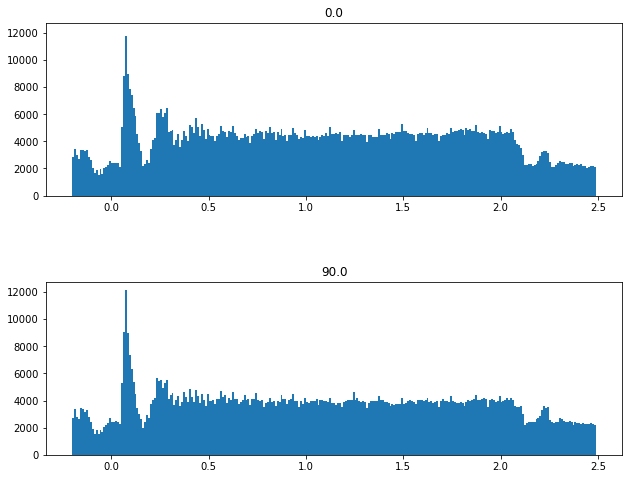

In [31]:
df.hist(column='time', by='orientation', 
        bins=time_base, 
        sharey=True, # force y axis range to be the same across plots
        xrot=0, 
        layout=(2,1),
        figsize=[10,8]
       )
plt.show()

Since we know there are 4 sort codes, we can also plot by both orientation and sort code. Here we turn off the `sharey` option, because the number of spikes varies by sort code. 

Note: This is actually not a valid thing to do from the point of view of the experiment, because the sort codes are unique to individual channels. That is, spike sorting is applied separately to each channel's data, so for example `sort_code==1` does not refer to the same neuron in channels 1 and 2. However, right now our main goal is to demonstrate how to compute and plot the PSTHs separately along two dimensions. Below we'll do that in a valid way, for all channels, but that's a lot (91), so let's start small.

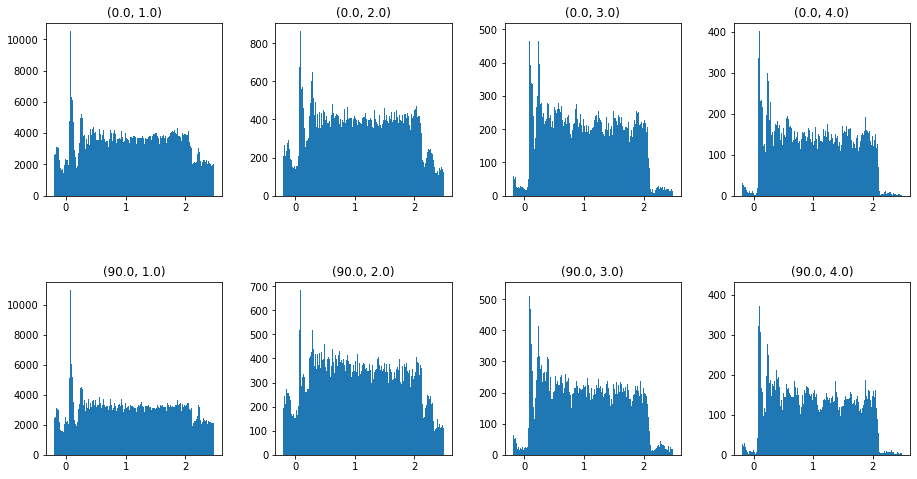

In [32]:
df.hist(column='time', by=['orientation', 'sort'], 
        bins=time_base, 
        sharey=False, xrot=0, 
        layout=(2,4),
        figsize=[15,8]
       )
plt.show()

### Using `np.histogram()`
We can also compute histograms using `np.histogram()`, without immediately plotting them. Instead, we save these histograms in memory, which allows more flexibility in how we later plot them. We need to loop over orientations and conditions. Below we demonstrate two ways to do this, one using a dictionary to hold the results, and the other using list comprehension. They are equally fast, and either one is valid. However, an advantage of the dictionary approach is that we use keys to the dictionary that clearly indicate what combination of orientation and sort code each histogram is associated with. In doing list comprehension, we have to generate a separate list of labels in parallel with the list containing the histograms (data) themselves. This is a bit less transparent (since unlike the dictionary, the labels aren't stored with the data, and requires attention to detail to ensure that the list of labels is in the same order as the list of histograms.

### The dictionary way

In [33]:
psth_dict = {}

for ortn in orientations:
    for sort in sort_codes:
        label = str(ortn) + '_' + str(sort)
        psth_dict[label] = np.histogram(df[(df['sort']==sort) & (df['orientation']==ortn)]['time'],
                                        bins=time_base,
                                       )

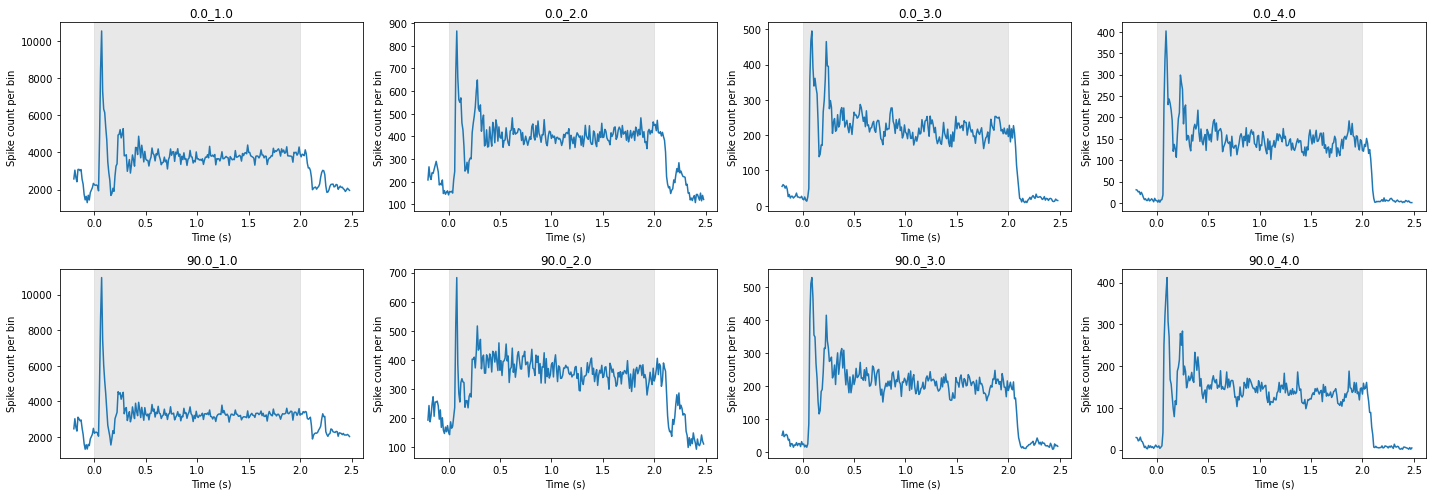

In [34]:
fig = plt.figure(figsize=[20,7])

for i,label in enumerate(psth_dict.keys()):
    ax = fig.add_subplot(num_ortns, len(sort_codes), i+1)
    ax.plot(psth_dict[label][1][:-1], psth_dict[label][0])
    # Show when stimulus was on
    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')

    ax.set_title(label)
    ax.set_ylabel('Spike count per bin')
    ax.set_xlabel('Time (s)')
    plt.tight_layout() # helps ensure titles and label text don't overlap
    
plt.show()    

Note above the differences in total spike counts (*y* axis) between sort codes. This is beacuse every channel as at least a sort code of 1 (one neuron/unit), but fewer channels were found to contain data from 2 or more units. So decreasing amounts of data contribute to the averages for sort codes 1-4.

### The list comprehension way

In [35]:
psth_list = [np.histogram(df[(df['sort']==sort) & (df['orientation']==ortn)]['time'],
                          bins=time_base,
                         ) 
        for ortn in orientations
        for sort in sort_codes]

# Generate the labels so we know what's what in the list above.
# Be sure to do the nested for loops in the same order (orientation then sort_code)
psth_list_labels = [[ortn, sort] for ortn in orientations for sort in sort_codes]

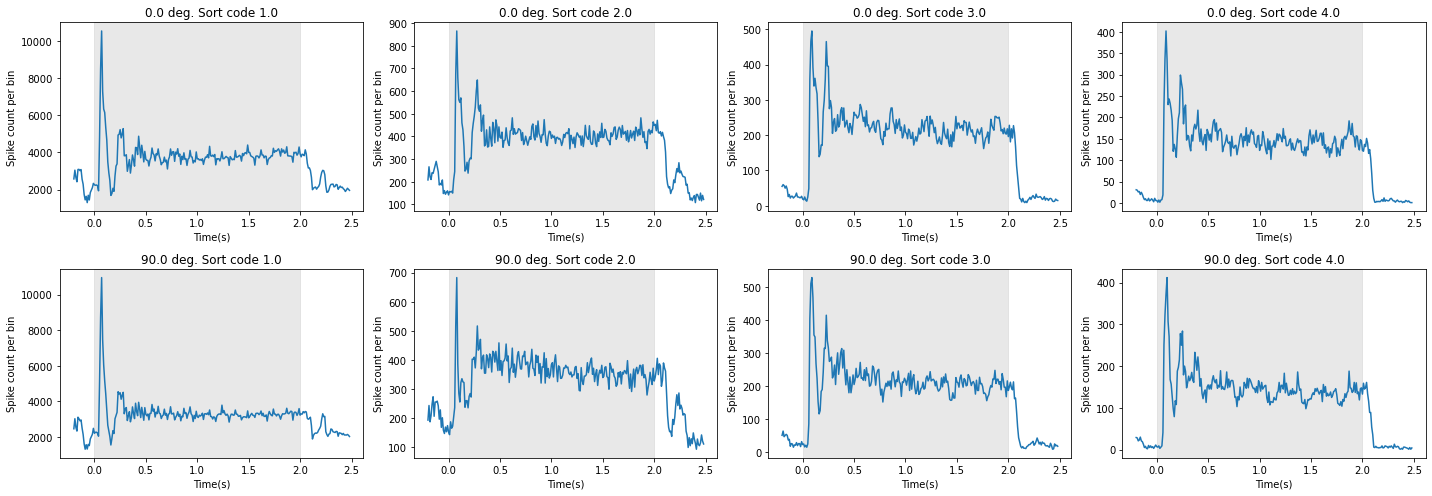

In [36]:
fig = plt.figure(figsize=[20,7])

for i in range(len(psth_list)):
    ax = fig.add_subplot(num_ortns, len(sort_codes), i+1)
    ax.plot(psth_list[i][1][:-1], psth_list[i][0])
    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
    ax.set_title(str(psth_list_labels[i][0]) + ' deg. Sort code ' + str(psth_list_labels[i][1]))
    ax.set_ylabel('Spike count per bin')
    ax.set_xlabel('Time(s)')
    plt.tight_layout() 
    
plt.show()    

# Overlapping lines

It's easier to make visual comparisons within a plot than between them. Since 0 and 90 degrees were the two experimental conditions that we'd want to compare, let's overlay them, keeping the separate panels for sort code. 

Note that this is a bit easier to do using the list method rather than the dictionary method, because in our list of labels, the orientation and sort code are two separate entries, so it's easy to pull out the orientations. Using the dictionary method, we'd need to parse the dictionary keys to pull out the orientation information.

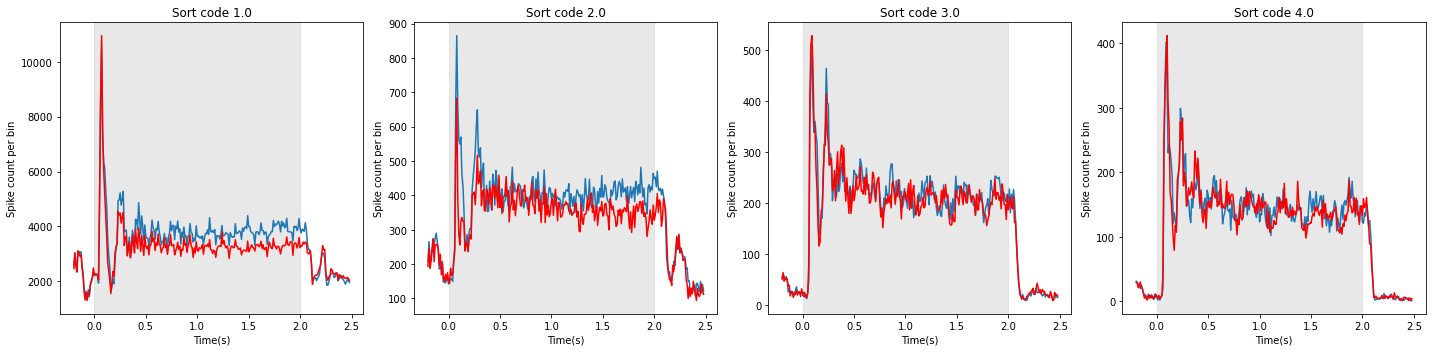

In [37]:
fig = plt.figure(figsize=[20,5])

for i in sort_codes:
    ax = fig.add_subplot(1, len(sort_codes), i)
    zero = psth_list_labels.index([0., i])
    ax.plot(psth_list[zero][1][:-1], psth_list[zero][0])
    ninety = psth_list_labels.index([90., i])
    ax.plot(psth_list[ninety][1][:-1], psth_list[ninety][0], color='red')

    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
    ax.set_title('Sort code ' + str(i))
    ax.set_ylabel('Spike count per bin')
    ax.set_xlabel('Time(s)')
    plt.tight_layout() 
    
plt.show()    

---
## PSTH for each channel

The above examples collapsed across all 96 channels in the microelectrode array. Let's now computer the PSTHs for each channel and orientation. 

In [38]:
psth = [np.histogram(df[(df['orientation']==ortn) & (df['channel']==chan)]['time'],
                     bins=time_base
                    )
        for ortn in orientations
        for chan in channels]

# Generate the labels so we know what's what in the list above.
# Be sure to do the nested for loops in the same order (orientation then sort_code)
psth_labels = [[ortn, chan] for ortn in orientations for chan in channels]

To plot these, we use similar code to above. However, because there are 96 channels, we want to remove some axis labels from most plots (so it's less messy and less redundant). There's no way to make this not a huge image, since there are 96 panels to show, but by setting it to 4 columns we attain a good balance between readability and size.

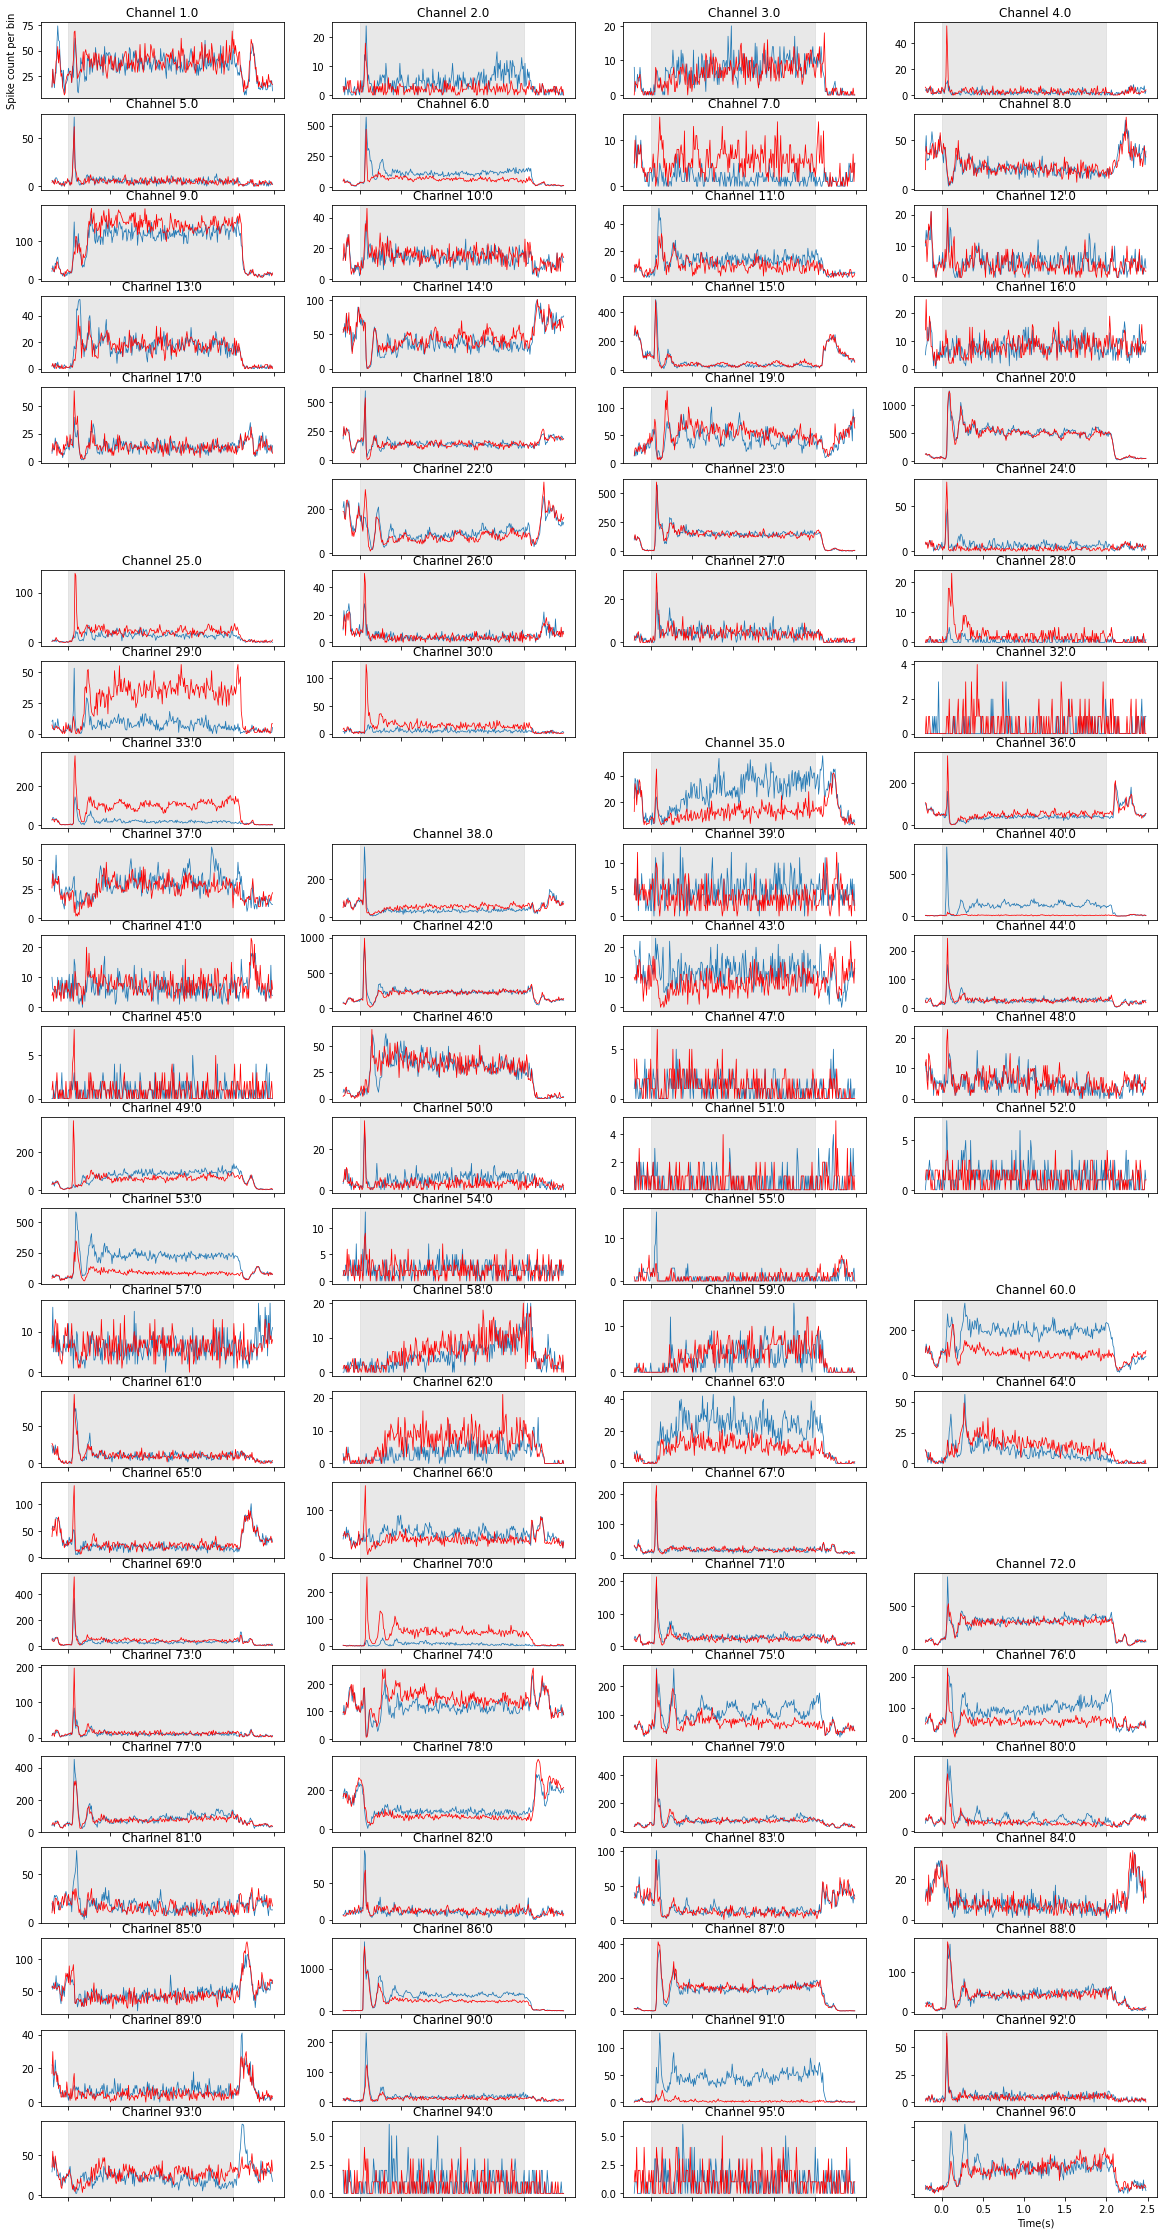

In [39]:
fig = plt.figure(figsize=[20, 40])

for i in channels:
    ax = fig.add_subplot(96/4, 4, i)
    zero = psth_labels.index([0., i])
    ax.plot(psth[zero][1][:-1], psth[zero][0], linewidth=.75)
    ninety = psth_labels.index([90., i])
    ax.plot(psth[ninety][1][:-1], psth[ninety][0], color='red', linewidth=.75)

    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')

    ax.set_title('Channel ' + str(i))

    if i== 1:
        ax.set_ylabel('Spike count per bin')
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
    elif i == max(channels):
        ax.set_xlabel('Time(s)')
        ax.set_ylabel('')
        ax.set_yticklabels('')
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_ylabel('')
    
plt.show()    

One thing you'll note above is that there are some missing panels, including channels 21, 31, 34, 56, and 68. As noted above, these are the dead channels. The way the code above is written, we use the channel number as the index for the subplot position. Since there is no channel in the `channels` list for the dead channels, those subplot panels are simply left blank.

Beyond that, it's clear that different channels show very different response profiles. Some (e.g., 1, 2, 4, 5) show clear transient peaks in spiking activity soon after stimulus onset. Others do not. Some of the channels that show this initial peak return to baseline (low) levels of firing soon after, while others (e.g., 1, 20, 72) show a sustained plateau as long as the stimulus is on. Others (e.g., 3, 62) show no initial peak, but a steady rise in firing rate as the stimulus duration increases. As well, a few channels show orientation sensitivity, with clearly different responses between 0 (blue) and 90 (red) degree gratings (e.g., 29, 63, 75, 76, 91).

## Interactive plots

Plotting all 91 channels is a bit visually overwhelming. It's useful in appreciating the whole range of responses in different channels, but each plot is quite small. Here we use `ipywidgets` to generate an interactive plot, with a drop-down menu to select the channel we want to view.

Note: To get this to work on your own system, you will need to run `jupyter labextension install @jupyter-widgets/jupyterlab-manager`

In [40]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def psth_i(chan=channels):
    fig = plt.figure(figsize=[15,5]) 

    zero = psth_labels.index([0., chan])
    plt.plot(psth[zero][1][:-1], psth[zero][0], 
             linewidth=.75,
             label='0 deg'
            )
    ninety = psth_labels.index([90., chan])
    plt.plot(psth[ninety][1][:-1], psth[ninety][0], 
             color='red', 
             linewidth=.75,
             label='90 deg'
            )
    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
    plt.legend()
    plt.title('Channel ' + str(int(chan)))
    plt.xlabel('Time (s)')
    plt.ylabel('Spike count per bin')

    plt.show()

interactive(children=(Dropdown(description='chan', options=(1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,…

---
## Correlating spike trains

### Compute correlation matrix 
Between each pair of channels' PSTH, for each orientation

In [41]:
corr_matrix = np.zeros(shape=(len(channels), len(channels), len(orientations)))
for row_ind, row_key in enumerate(channels): 
    for col_ind, col_key in enumerate(channels): 
        for oind, ortn in enumerate(orientations): 
            corr_matrix[row_ind, col_ind, oind], pvals = sc.pearsonr(psth[psth_labels.index([ortn, row_key])][0], 
                                                                     psth[psth_labels.index([ortn, col_key])][0]  
                                                                    ) 

#### Visualize the matrix

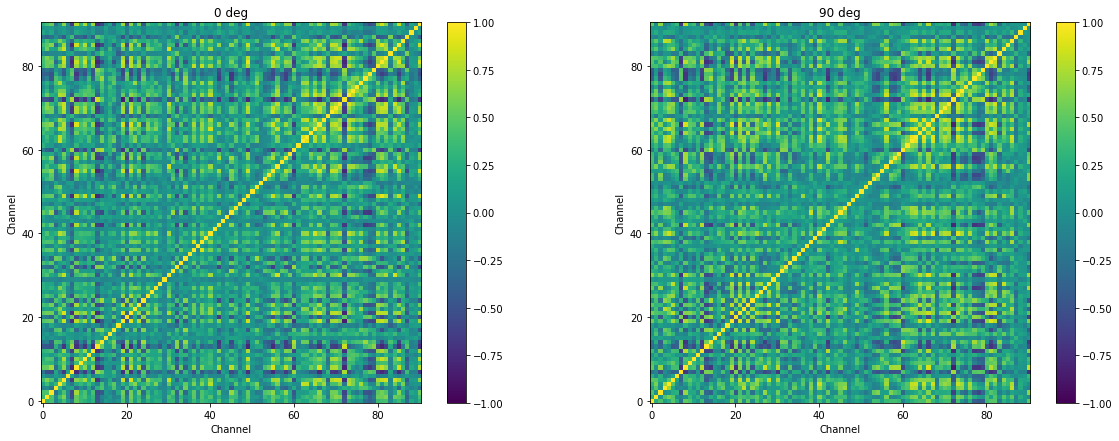

In [42]:
fig = plt.figure(figsize=[20,7])

for oind, ortn in enumerate(orientations):
    ax = fig.add_subplot(1, 2, oind+1)
    plt.imshow(corr_matrix[:,:,oind], clim=(-1, 1), cmap='viridis')
    ax.invert_yaxis()
    plt.colorbar()
    plt.title(str(int(ortn)) + ' deg')
    plt.xlabel('Channel')
    plt.ylabel('Channel')

Nylen and Wallisch go on to show how we can tidy up the correlation matrix to focus on information of interest, while eliminating distracting or irrelevant factors (noise; where "noise" can be defined as "information not relevant to the research question"). 

These steps include:
- remove noisy channels
- use data only from the time points when the stimulus was on
- smooth the PSTHs by convolving with a kernel

### Remove noisy channels

Nylen and Wallisch provide a list of these for us, which we will use for convenience. If you cross-referenec the channels in the list below, with the plot of all 91 channels above, you'll be able to see that these are indeed noisy looking. For example, they don't show an initial peak after stimulus onset, nor any apparent relationship with the stimulus.

In general, "eyeballing" data to remove noise is the least-desirable way to do this. It is highly subjective, meaning that it is sensitive to individual bias, and is not reproducible scientific practice. It is better to define objective criteria to categorize noise. However, for now we will take the list of noisy channels as a given for the sake of focusing on improving the correlation matrix.

To do this we will go back to the original pandas DataFrame and slice that, because it's so fast and easy.

In [43]:
noisy = [7, 16, 32, 37, 39, 41, 43, 45, 47, 48, 51, 52, 54, 94, 95]
df_clean = df[~df['channel'].isin(noisy)]
clean_chans = sorted(df_clean['channel'].unique())

In [44]:
psth_clean = [np.histogram(df_clean[(df_clean['orientation']==ortn) & (df_clean['channel']==chan)]['time'],
                           bins=time_base
                           )
              for ortn in orientations
              for chan in clean_chans]

# Generate the labels so we know what's what in the list above.
# Be sure to do the nested for loops in the same order (orientation then sort_code)
psth_labels = [[ortn, chan] for ortn in orientations for chan in clean_chans]

In [45]:
corr_matrix_clean = np.zeros(shape=(len(clean_chans), len(clean_chans), len(orientations)))
pvals = np.zeros(shape=(len(clean_chans), len(clean_chans), len(orientations)))

for row_ind, row_key in enumerate(clean_chans): 
    for col_ind, col_key in enumerate(clean_chans): 
        for oind, ortn in enumerate(orientations): 
            corr_matrix_clean[row_ind, col_ind, oind], pvals[row_ind, col_ind, oind] = sc.pearsonr(psth_clean[psth_labels.index([ortn, row_key])][0],
                                                                           psth_clean[psth_labels.index([ortn, col_key])][0]  
                                                                          ) 

#### Visualize the matrix

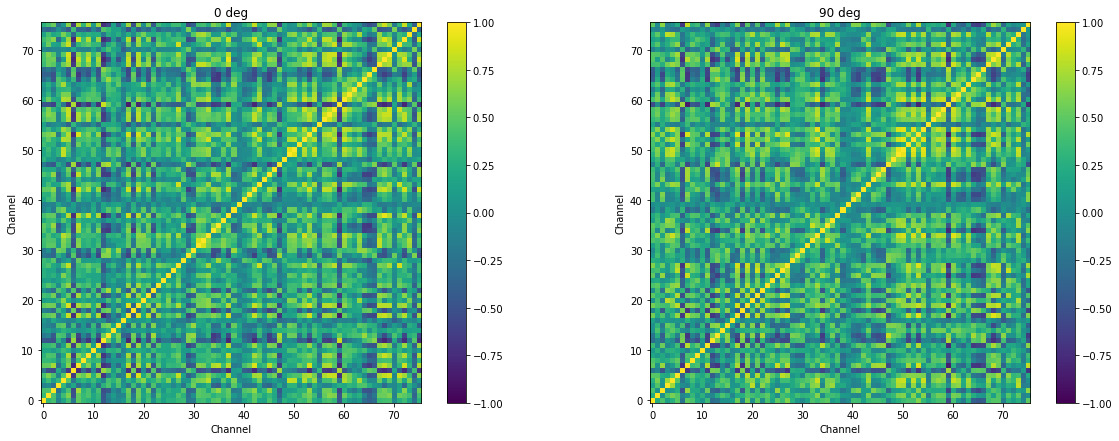

In [46]:
fig = plt.figure(figsize=[20,7])

for oind, ortn in enumerate(orientations):
    ax = fig.add_subplot(1, 2, oind+1)
    plt.imshow(corr_matrix_clean[:,:,oind], clim=(-1, 1), cmap='viridis')
    ax.invert_yaxis()
    plt.colorbar()
    plt.title(str(int(ortn)) + ' deg')
    plt.xlabel('Channel')
    plt.ylabel('Channel')

### Restrict time range

In [47]:
df_stim = df_clean[(df_clean['time'] > grating_on_time) & (df_clean['time'] < grating_off_time)]

# Also need to restrict the time_base for computing histograms
time_base_stim = np.arange(grating_on_time, grating_off_time, .01) 

In [48]:
psth_stim = [np.histogram(df_stim[(df_stim['orientation']==ortn) & (df_stim['channel']==chan)]['time'],
                     bins=time_base_stim
                    )
        for ortn in orientations
        for chan in clean_chans]

In [49]:
corr_matrix_stim = np.zeros(shape=(len(clean_chans), len(clean_chans), len(orientations)))
for row_ind, row_key in enumerate(clean_chans): 
    for col_ind, col_key in enumerate(clean_chans): 
        for oind, ortn in enumerate(orientations): 
            corr_matrix_stim[row_ind, col_ind, oind], pvals = sc.pearsonr(psth_stim[psth_labels.index([ortn, row_key])][0],
                                                                          psth_stim[psth_labels.index([ortn, col_key])][0]  
                                                                          ) 

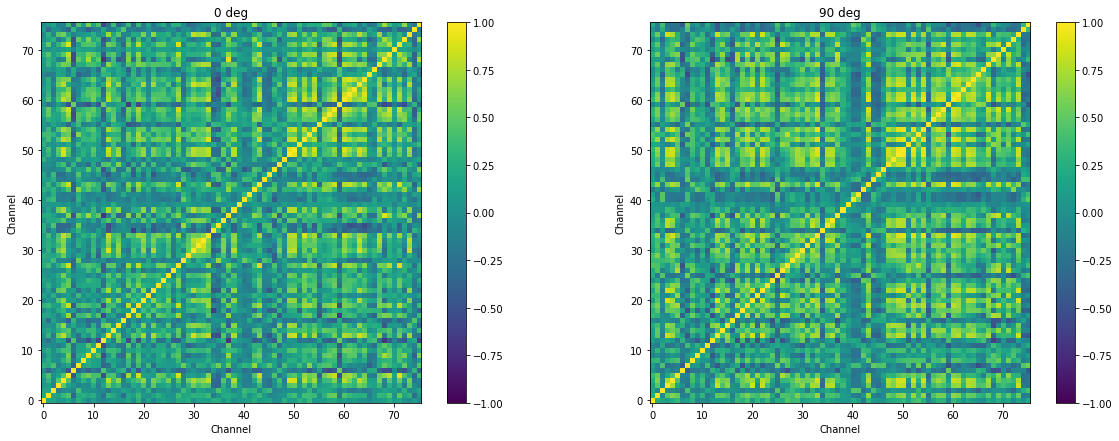

In [50]:
fig = plt.figure(figsize=[20,7])

for oind, ortn in enumerate(orientations):
    ax = fig.add_subplot(1, 2, oind+1)
    plt.imshow(corr_matrix_stim[:,:,oind], clim=(-1, 1), cmap='viridis')
    ax.invert_yaxis()
    plt.colorbar()
    plt.title(str(int(ortn)) + ' deg')
    plt.xlabel('Channel')
    plt.ylabel('Channel')